<a href="https://colab.research.google.com/github/soyebganja/DL-Practice-Projects/blob/main/9%3AModel%20Optimization%3A%20Regularization%20Techniques/9_4_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [26]:
# Load and normalize the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(full_train_dataset, range(5000))
test_subset = Subset(full_test_dataset, range(1000))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

### Train a Neural Network Without Batch Normalization

In [27]:
# Define the model
class MNISTClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 10)
    )

  def forward(self, x):
    return self.network(x)

In [28]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            if (batch) % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # validation phase
        model.eval()
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.long())
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)

    return val_accuracies

In [29]:
# Instantiate the model, define loss function and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_accuracies_no_bn = train_model(model, train_loader, test_loader, criterion, optimizer, 10)

Epoch [0/10], Batch [0/79], Loss: 2.2986
Epoch [1/10], Batch [0/79], Loss: 0.4994
Epoch [2/10], Batch [0/79], Loss: 0.3708
Epoch [3/10], Batch [0/79], Loss: 0.3911
Epoch [4/10], Batch [0/79], Loss: 0.2130
Epoch [5/10], Batch [0/79], Loss: 0.2196
Epoch [6/10], Batch [0/79], Loss: 0.1511
Epoch [7/10], Batch [0/79], Loss: 0.2090
Epoch [8/10], Batch [0/79], Loss: 0.0793
Epoch [9/10], Batch [0/79], Loss: 0.1748


In [30]:
print(val_accuracies_no_bn)

[0.839, 0.84, 0.873, 0.885, 0.878, 0.884, 0.895, 0.893, 0.9, 0.888]


### Train a Neural Network With Batch Normalization

In [31]:
# Define the model
class MNISTClassifierWithBN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(64, 10)
    )

  def forward(self, x):
    return self.network(x)

In [32]:
# Instantiate the model, define loss function and optimizer
model_with_bn = MNISTClassifierWithBN().to(device)
criterion_with_bn = nn.CrossEntropyLoss()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)

val_accuracies_with_bn = train_model(model_with_bn, train_loader, test_loader, criterion_with_bn, optimizer_with_bn, 10)

Epoch [0/10], Batch [0/79], Loss: 2.4408
Epoch [1/10], Batch [0/79], Loss: 0.3935
Epoch [2/10], Batch [0/79], Loss: 0.1358
Epoch [3/10], Batch [0/79], Loss: 0.1423
Epoch [4/10], Batch [0/79], Loss: 0.1428
Epoch [5/10], Batch [0/79], Loss: 0.0792
Epoch [6/10], Batch [0/79], Loss: 0.0502
Epoch [7/10], Batch [0/79], Loss: 0.0197
Epoch [8/10], Batch [0/79], Loss: 0.0399
Epoch [9/10], Batch [0/79], Loss: 0.0089


In [33]:
print(val_accuracies_with_bn)

[0.889, 0.911, 0.913, 0.92, 0.928, 0.937, 0.934, 0.938, 0.94, 0.933]


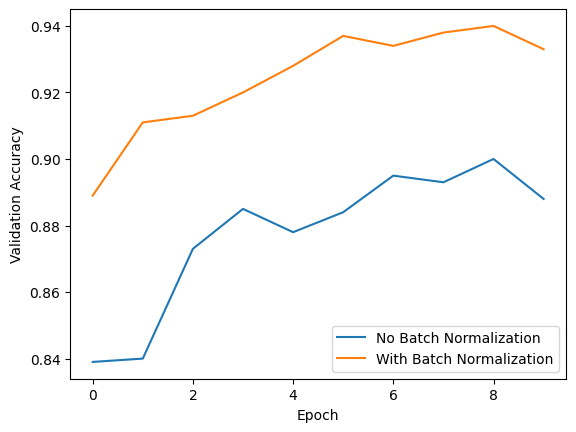

In [34]:
plt.plot(val_accuracies_no_bn, label='No Batch Normalization')
plt.plot(val_accuracies_with_bn, label='With Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()